In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('Bank Customer Churn Prediction.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [3]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# Split Data
> <p style="font-size:16px">Before we do ANYTHING, let's split our data!</p>
> <p style="font-size:16px">We don't want to find patterns in the data that may influence how we build our ML model.</p>

In [4]:
X = df.drop('churn', axis = 1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)

# Investigate Data

In [5]:
df = pd.merge(X_train, y_train, left_index = True, right_index = True, how = 'inner')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
6963,15595447,613,Spain,Male,39,8,118201.41,1,1,0,23315.59,0
9084,15593499,686,Spain,Female,47,6,0.00,1,1,0,32080.69,1
3396,15720354,581,France,Male,71,4,0.00,2,1,1,197562.08,0
1216,15682528,572,France,Male,33,5,0.00,1,0,1,41139.05,0
2545,15687130,686,France,Female,43,0,0.00,1,1,1,170072.90,0


In [6]:
df.groupby('churn').mean(numeric_only = True)

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
churn,,,,,,,,,
0,1.569184e+07,651.758599,37.449031,5.042839,73140.886621,1.541276,0.706535,0.553784,99798.907076
1,1.568917e+07,644.447631,44.849751,4.904613,92442.084458,1.481920,0.693890,0.362219,101337.880867


# Continuous Variable Exploration

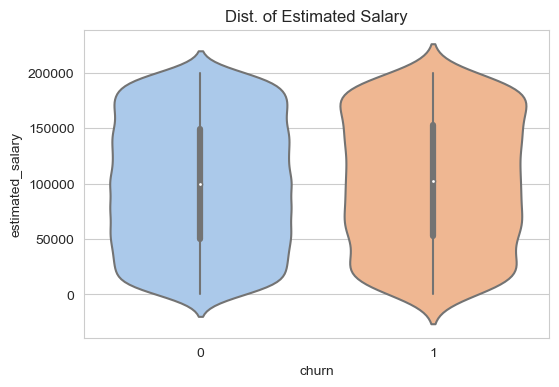

In [7]:
plt.figure(figsize = (6,4))
sns.violinplot(data = df, x = 'churn', y = 'estimated_salary')
plt.title("Dist. of Estimated Salary")
plt.show()

><p style="font-size:18px;color:DodgerBlue">There doesn't seem to be any difference in estimated salaries between customers who curn.</p>

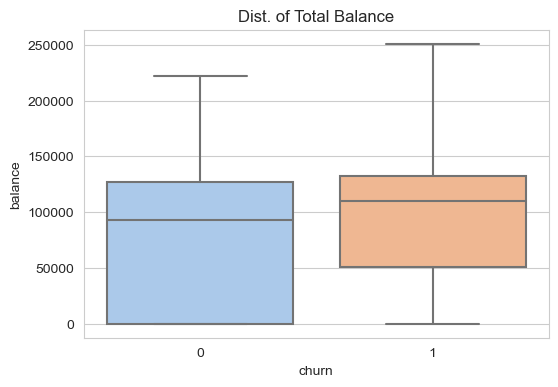

In [8]:
plt.figure(figsize = (6,4))
sns.boxplot(data = df, x = 'churn', y = 'balance')
plt.title("Dist. of Total Balance")
plt.show()

><p style="font-size:17px;color:DodgerBlue">Customers who churn have a higher median balance than customers who don't churn</p>

# Discrete Variable Exploration

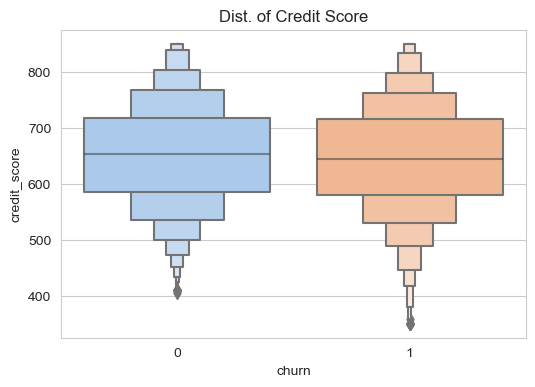

In [9]:
plt.figure(figsize = (6,4))
sns.boxenplot(data = df, x = 'churn', y = 'credit_score')
plt.title("Dist. of Credit Score")
plt.show()

><p style="font-size:18px;color:DodgerBlue">Customers who churn tend to have lower median credit scores.</p>

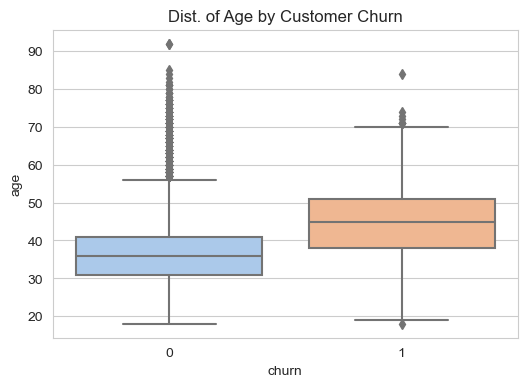

In [10]:
plt.figure(figsize = (6,4))
sns.boxplot(data = df, x = 'churn', y = 'age')
plt.title('Dist. of Age by Customer Churn')
plt.show()

><p style="font-size:18px;color:DodgerBlue">Customers who churn have a higher median age.</p>

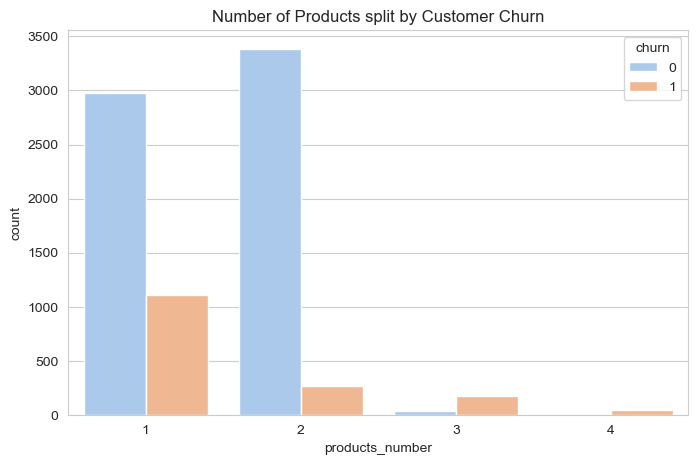

In [11]:
plt.figure(figsize = (8,5))
sns.countplot(data = df, x = 'products_number', hue = 'churn')
plt.title("Number of Products split by Customer Churn")
plt.show()

><p style="font-size:18px;color:DodgerBlue">
    Customers who have 3 or more products are disproportionately more likely to churn
</p>

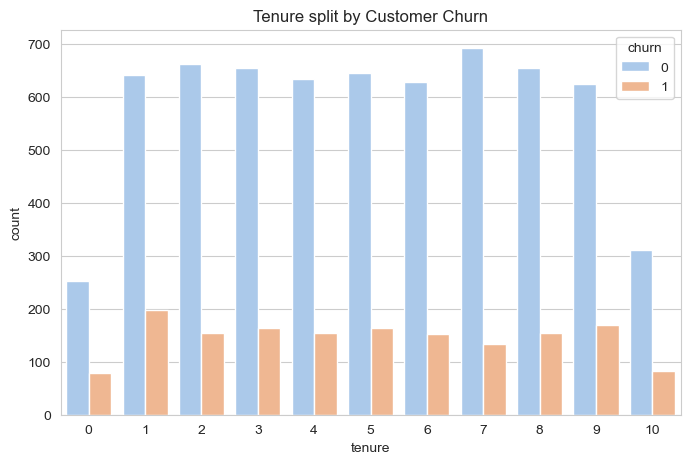

In [12]:
plt.figure(figsize = (8,5))
sns.countplot(data = df, x = 'tenure', hue = 'churn')
plt.title('Tenure split by Customer Churn')
plt.show()

><p style="font-size:18px;color:DodgerBlue">
    There doesn't seem to be any significant difference in customer tenure between those who churn and those who don't churn.
</p>

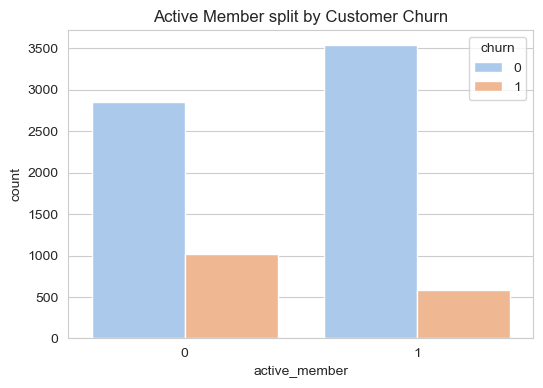

In [13]:
plt.figure(figsize = (6,4))
sns.countplot(data = df, x = 'active_member', hue = 'churn')
plt.title("Active Member split by Customer Churn")
plt.show()

><p style="font-size:18px;color:DodgerBlue">
    Active members are much less likely to churn!
</p>

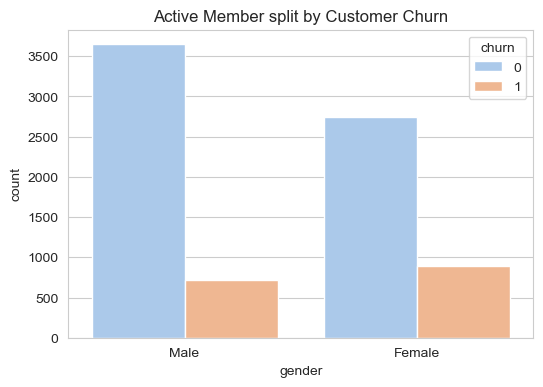

In [14]:
plt.figure(figsize = (6,4))
sns.countplot(data = df, x = 'gender', hue = 'churn')
plt.title("Active Member split by Customer Churn")
plt.show()

><p style="font-size:18px;color:DodgerBlue">
    Females are more likely than males to churn!
</p>

# Feature Selection

<p style="font-size:15px">
    Based on the above EDA, it is time to select which variables should be used in our ML model!
</p>

<h3>
    Features we're using
</h3>

> 1. Credit Score
> 2. Age
> 3. Balance
> 4. Products Number
> 5. Active Member
> 6. Gender

# Modeling

<p style="font-size: 16px">We've already split our data above, so let's get right into building our model!</p>

In [15]:
# preparing data for machine learning algorithm

features = ['credit_score', 'gender', 'age', 'tenure', 'products_number', 'active_member']
X_train = X_train[features].copy()
X_test = X_test[features].copy()


X_train.gender.replace({'Female': 0, 'Male': 1}, inplace = True)
X_test.gender.replace({'Female': 0, 'Male': 1}, inplace = True)

# Train Models

In [16]:
rf = RandomForestClassifier(max_depth = 9, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, random_state=42)

In [17]:
xgb = XGBClassifier(n_estimators = 100, max_depth = 9)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Evaluate Models 

In [18]:
df_test = pd.merge(X_test[features], y_test, left_index = True, right_index = True, how = 'inner')
df_test['RandForestPred'] = rf.predict(X_test[features])
df_test['XgbPred'] = xgb.predict(X_test[features])

In [19]:
rf_accuracy = accuracy_score(df_test.churn, df_test.RandForestPred)
rf_precision = precision_score(df_test.churn, df_test.RandForestPred)
rf_recall = recall_score(df_test.churn, df_test.RandForestPred)

xgb_accuracy = accuracy_score(df_test.churn, df_test.XgbPred)
xgb_precision = precision_score(df_test.churn, df_test.XgbPred)
xgb_recall = recall_score(df_test.churn, df_test.XgbPred)


pd.DataFrame(data = [[rf_accuracy, rf_precision, rf_recall], [xgb_accuracy, xgb_precision, xgb_recall]],
             index = ['Random Forest', 'XGBoost Forest'],
             columns = ['Accuracy', 'Precision', 'Recall'])

,Accuracy,Precision,Recall
Random Forest,0.848,0.827411,0.376443
XGBoost Forest,0.828,0.666667,0.411085


><p style="font-size:18px;color:DodgerBlue">The Random Forest Classifier seems to be the more promising model, let's work on tuning its hyperparameters!</p>

# GridSearchCV

In [20]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9, 11],
    'min_samples_split': [2, 6, 10],
}

In [21]:
rf_grid = GridSearchCV(rf, param_grid = param_grid, cv = 5, scoring = 'accuracy')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=9, random_state=42),
             param_grid={'max_depth': [5, 7, 9, 11],
                         'min_samples_split': [2, 6, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [22]:
cvres = rf_grid.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.85725 {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.8577499999999999 {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
0.858 {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}
0.857 {'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 100}
0.857625 {'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 200}
0.8578749999999999 {'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 300}
0.857625 {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.85725 {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
0.85825 {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 300}
0.85875 {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 100}
0.858875 {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 200}
0.85925 {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 300}
0.858625 {'max_depth': 7, 'min_samples_split': 6, 'n_estimators': 100}
0.859125 {'max_depth': 7, 'min_samples_split': 6, 'n_estimators':

In [23]:
final_rf = rf_grid.best_estimator_
final_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_split=6, n_estimators=300,
                       random_state=42)

In [24]:
df_test['FinalPred'] = final_rf.predict(X_test[features])

final_accuracy = accuracy_score(df_test.churn, df_test.FinalPred)
final_precision = precision_score(df_test.churn, df_test.FinalPred)
final_recall = recall_score(df_test.churn, df_test.FinalPred)

pd.DataFrame(data = [[final_accuracy, final_precision, final_recall]],
             index = ['Final Results'],
             columns = ['Accuracy', 'Precision', 'Recall'])

,Accuracy,Precision,Recall
Final Results,0.8505,0.848958,0.376443
